In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
plt.rcParams['figure.figsize'] = (30, 30)

import re
import spacy
from bs4 import BeautifulSoup
from IPython.core.display import display, HTML

import numpy as np
import pandas as pd
import networkx as nx

from umap import UMAP
from sklearn.cluster import KMeans, AgglomerativeClustering

from tqdm import tqdm_notebook as tqdm

In [2]:
df = pd.read_json('data/calm_records.json')

In [3]:
df['AltRefNo'] = df['AltRefNo'].dropna().apply(lambda x: x[0])
df['Level'] = df['Level'].dropna().apply(lambda x: x[0])

In [4]:
collection_ids = [id for id in sorted(df['AltRefNo'][df['Level'] == 'Collection'].values)]

In [5]:
df = df.set_index('AltRefNo')

In [6]:
collection_descriptions = (df['AdminHistory']
                           [collection_ids]
                           .dropna()
                           .apply(lambda x: x[0]))
collections

In [7]:
ent_types = ['PERSON', 
             'NORP', 
             'FACILITY', 
             'ORG', 
             'GPE', 
             'LOC', 
             'PRODUCT', 
             'EVENT', 
             'WORK_OF_ART', 
             'LAW', 
             'LANGUAGE']

In [8]:
nlp = spacy.load('en')

In [9]:
entities_in_descriptions = pd.Series()
for id, record in tqdm(list(collection_descriptions.items())):
    plain_text = BeautifulSoup(record, 'html.parser').get_text()
    doc = nlp(plain_text)
    entities_in_descriptions[id] = [str(ent) for ent in doc.ents]

HBox(children=(IntProgress(value=0, max=874), HTML(value='')))

In [51]:
def flatten(list_of_lists):
    return [j for i in list_of_lists for j in i]

In [52]:
unique_entities = np.unique(flatten(entities_in_descriptions))

In [17]:
occurences = pd.DataFrame(data=[[entities_in_descriptions[collection].count(entity) 
                                 for entity in unique_entities]
                                for collection in tqdm(collection_descriptions.index.values)],
                          index=collection_descriptions.index.values,
                          columns=unique_entities)

HBox(children=(IntProgress(value=0, max=874), HTML(value='')))

In [18]:
occurences

,,,Natural Childbirth Association,Nuisances Removal and Disease Prevention Act,System,1935,,1st Assistant,50th,Abolition,...,year-long,year1970 Coventry,yearly,years,Tubby Clayton,to,£1m,£2 million,£6 million,Étudiant de médecine'
3473,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8855,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAU/FAS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AML,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ART/AFH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ART/COO,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ART/GEO,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ART/IOW,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ART/LAB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ART/MIW,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
adjacency = pd.DataFrame(data=occurences.values.T.dot(occurences.values),
                         index=unique_entities,
                         columns=unique_entities)

In [75]:
adjacency.shape

(15486, 15486)

In [76]:
G = nx.from_pandas_adjacency(adjacency)

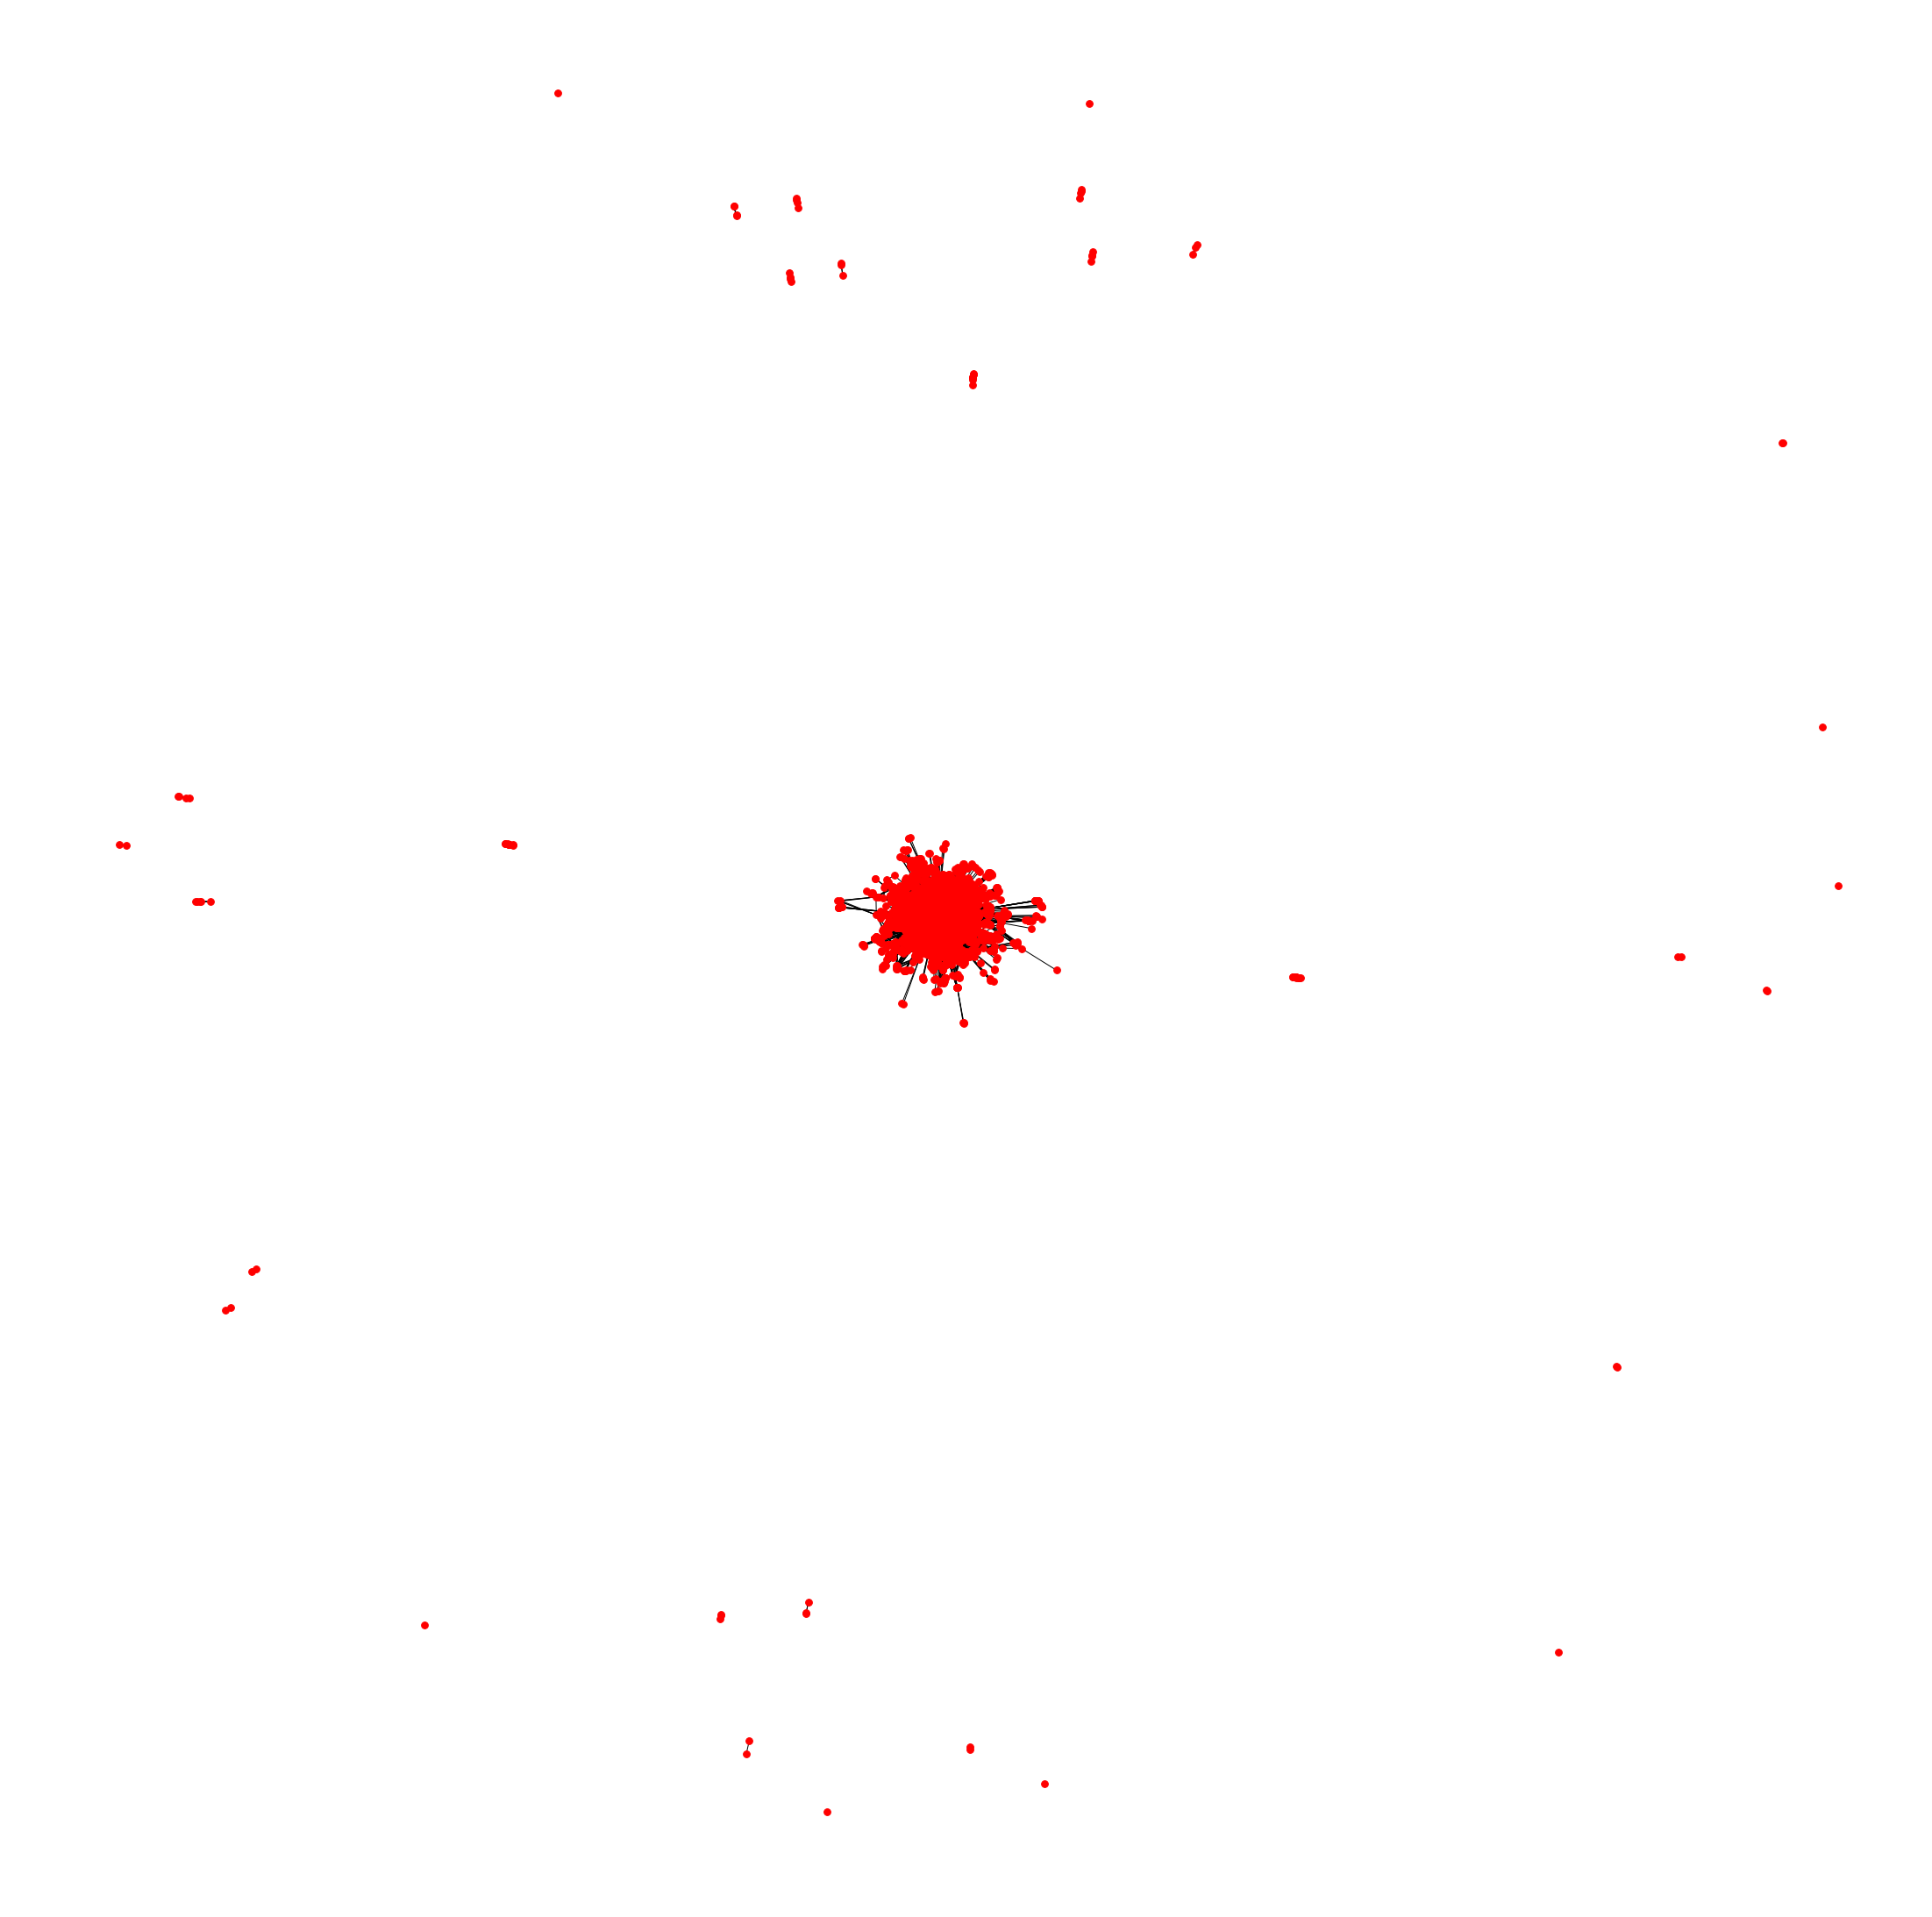

In [77]:
nx.draw_spring(G, node_size=60)

In [91]:
from sklearn.decomposition import PCA

embedding_nd = pd.DataFrame(PCA(n_components=50)
                              .fit_transform(adjacency))

In [92]:
embedding_2d = pd.DataFrame(UMAP(n_components=2).fit_transform(embedding_nd.values))

embedding_2d.plot.scatter(x=0, y=1);

KeyboardInterrupt: 

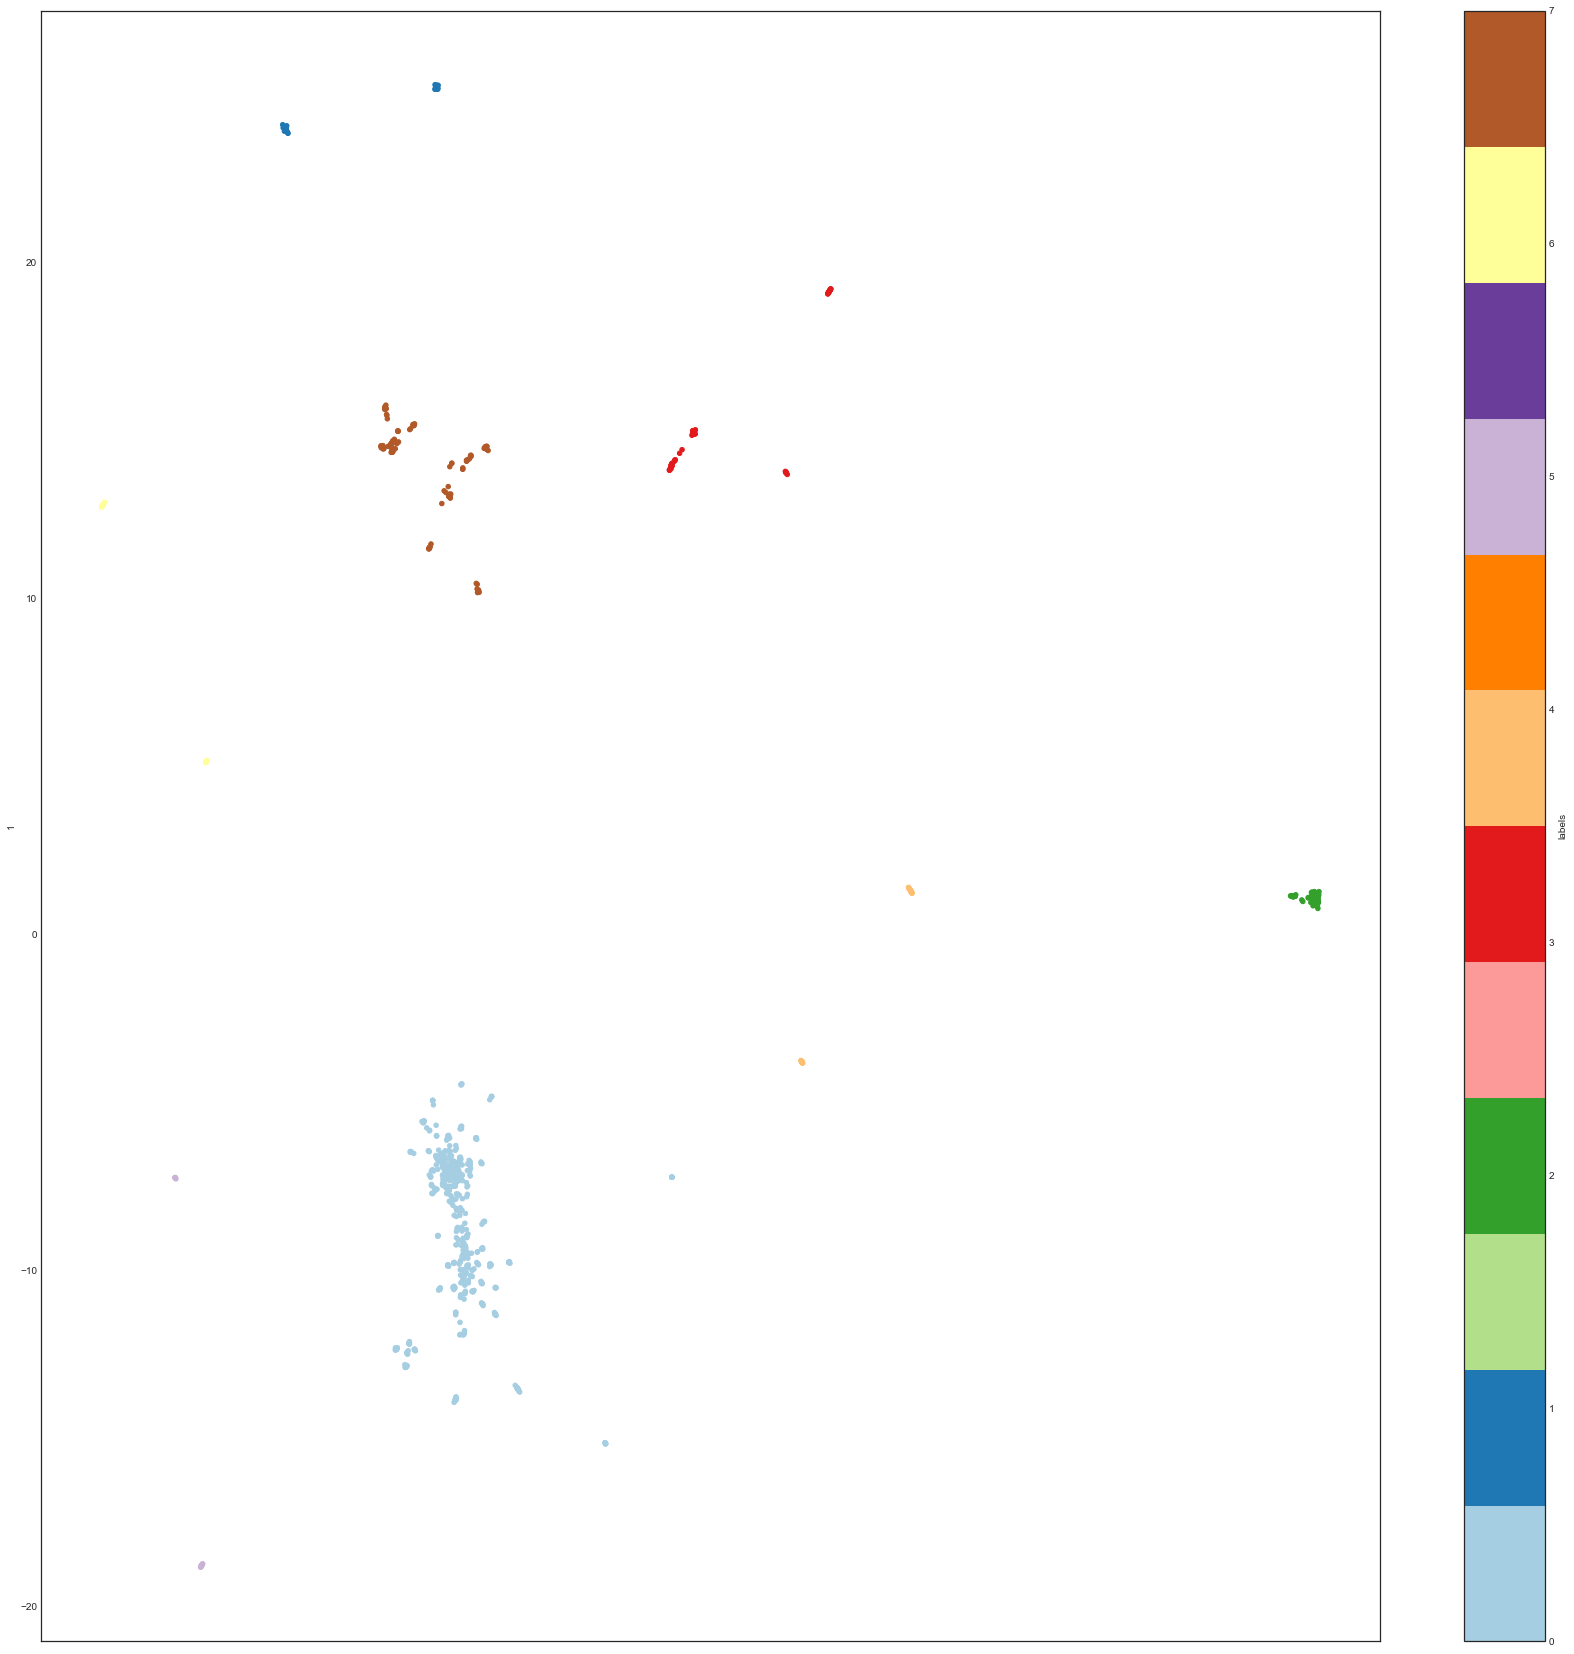

In [80]:
n_clusters = 8
embedding_2d['labels'] = KMeans(n_clusters).fit_predict(embedding_2d.values)
embedding_2d.plot.scatter(x=0, y=1, c='labels', cmap='Paired');

In [72]:
cluster = 7
collection_ids_in_cluster = (collection_descriptions.index.values
                             [embedding_2d[embedding_2d['labels'] == cluster]
                              .index.values])
collection_ids_in_cluster

array(['MS.6243', 'MSS.1020-1021', 'MSS.1164-1165', 'MSS.1253-1266',
       'MSS.1289-1290', 'MSS.1630-1631', 'MSS.1703-1704', 'MSS.2420-2421',
       'MSS.2425-2432', 'MSS.2464-2465', 'MSS.2498-2499', 'MSS.2511-2515',
       'MSS.3443, 5652, 7061 & 7310', 'MSS.3767 and 7374',
       'MSS.3930-3946', 'MSS.5036-5088 and 8049', 'MSS.6824, 7148 & 7691'],
      dtype=object)

In [73]:
pd.Series(flatten(entities_in_descriptions[collection_ids_in_cluster].tolist())).value_counts()

Paris                                     21
M.D.                                       4
the Faculté de Médecine                    3
annual                                     2
1820                                       2
the Medico-Botanical Society of London     2
Jean Nicolas Marjolin                      2
the Académie de Médecine                   2
1828                                       2
G.J. Witkowski                             2
Académie                                   2
the American Ambulance Service             1
Saulieu                                    1
1780-1850                                  1
Louis Philippe                             1
Doctorate                                  1
La Salpêtrière                             1
Marjolin                                   1
the St. Lazare Hospital                    1
1880                                       1
1672-1731                                  1
Bethlem Hospital                           1
1812-1895 